In [72]:
# Load from pkl files
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


with open('./Input/8-mers/mic_dframe.pkl', 'rb') as file:
    mic_dframe = pickle.load(file)
with open('./Input/8-mers/suscep_classes.pkl', 'rb') as file:
    suscep_classes = pd.read_pickle(file)
    

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

antibiotics = mic_dframe.columns[-12:]

def prob_to_onehot(y):
    for i in range(0, y.shape[0]):
        greater = 0
        pos = 0
        for j in range(0, y.shape[1]):
            if y[i][j] >= greater:
                greater = y[i][j]
                pos = j
            y[i][j] = 0.0
        y[i][pos] = 1.0
    return y

def best_N_features(target_df, antibiotic, N):
    path = './input/8-mers/counts/'
    genome_ids = target_df['Genome ID'].loc[pd.notnull(target_df[antibiotic])].values
    X = np.array([np.load(path + genome_id + '.npy') for genome_id in genome_ids])
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./input/8-mers/kmers_basis.npy')
    selected_kmers = [column[0]  for column in zip(kmers, n_best.get_support()) if column[1]]
    #scores = k_best.fit(X,y).scores_
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    return best_feature_df

def class_weighting(df, antibiotic, cv):
    # Unique mic values
    mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].unique()
    # Samples per class
    samples = {mic : len(df.loc[df[antibiotic]==mic]) for mic in mics}
    # Sorted classes
    mics = sorted([key for key in samples.keys()])
    # total data
    total = len(df.loc[pd.notnull(df[antibiotic])])
    # class weights
    class_weight = {i: (1 / samples[mic])*(total/len(mics))*(1/cv) for i, mic in enumerate(mics)}
    
    return class_weight

models = {}
callbacks = {}
N_epochs = {}

**ciprofloxacin**

In [73]:

antibiotic = 'ciprofloxacin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 43.60 seconds
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
Test set accuracy: 0.6750700280112045
Best Validation Loss: 1.36
Best Validation Accuracy: 0.69
Best Train Loss: 0.50
Best Train Accuracy: 0.87


Text(0.5, 25.722222222222214, 'Predicted label')

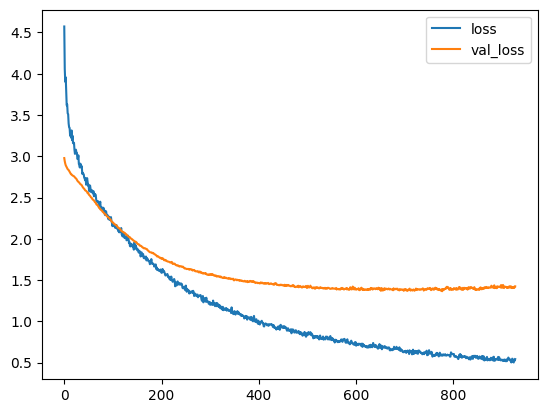

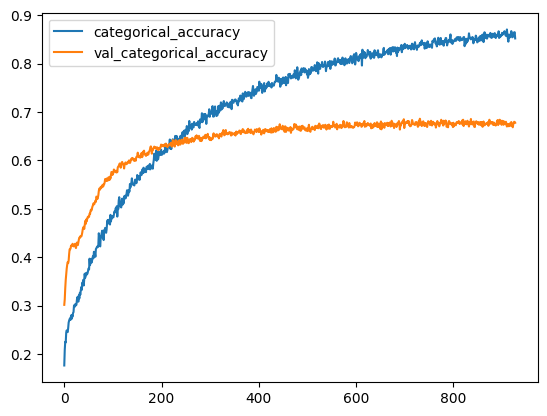

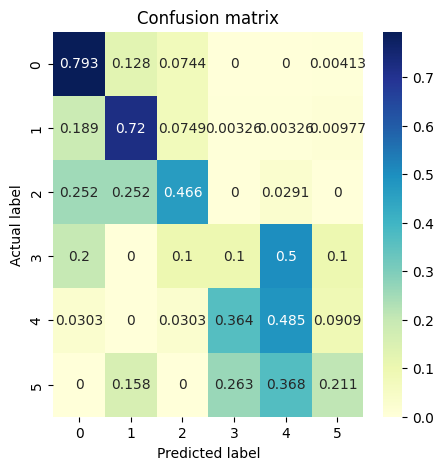

In [74]:

# Model building function
def make_model_ciprofloxacin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=150,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_ciprofloxacin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=5000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:5000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**trimethoprim/sulfamethoxazole**

In [75]:

antibiotic = 'trimethoprim/sulfamethoxazole'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 35.83 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Test set accuracy: 0.8951367781155015
Best Validation Loss: 0.65
Best Validation Accuracy: 0.92
Best Train Loss: 0.19
Best Train Accuracy: 0.98


Text(0.5, 25.722222222222214, 'Predicted label')

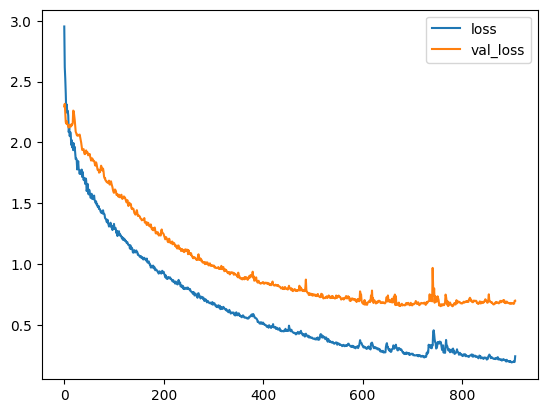

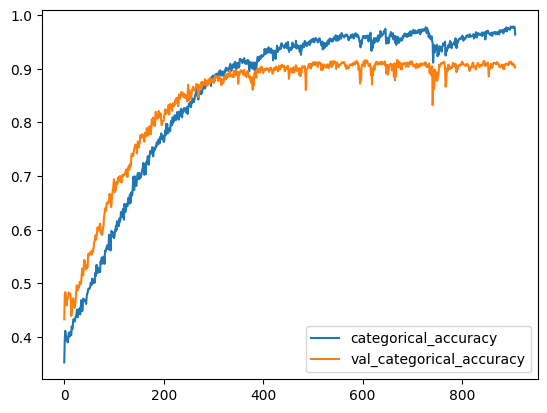

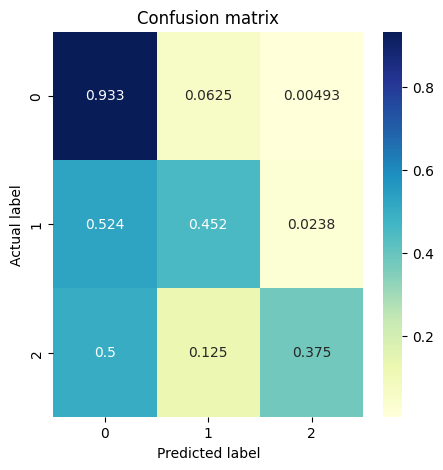

In [76]:

# Model building function
def make_model_trimethoprim_sulfamethoxazole(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.007),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=150,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_trimethoprim_sulfamethoxazole()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=2000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:2000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**ceftriaxone**

In [77]:

antibiotic = 'ceftriaxone'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 40.15 seconds
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.8809869375907112
Best Validation Loss: 0.57
Best Validation Accuracy: 0.90
Best Train Loss: 0.18
Best Train Accuracy: 0.99


Text(0.5, 25.722222222222214, 'Predicted label')

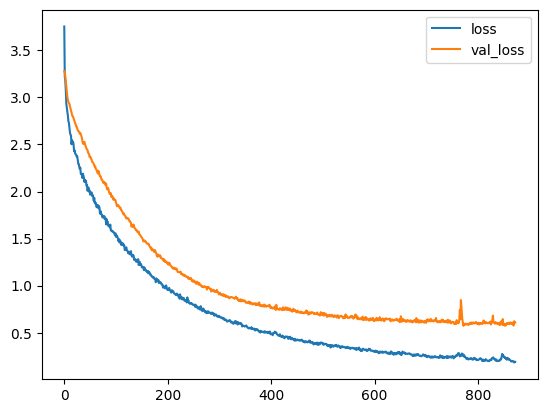

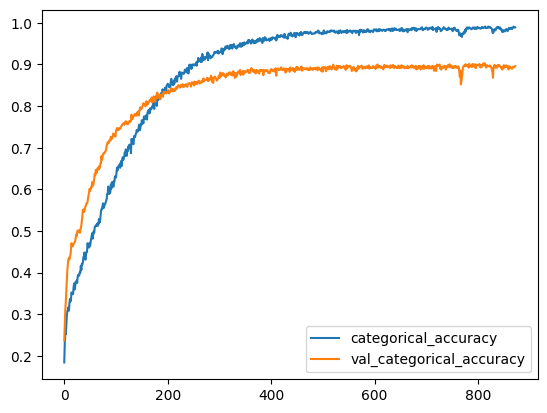

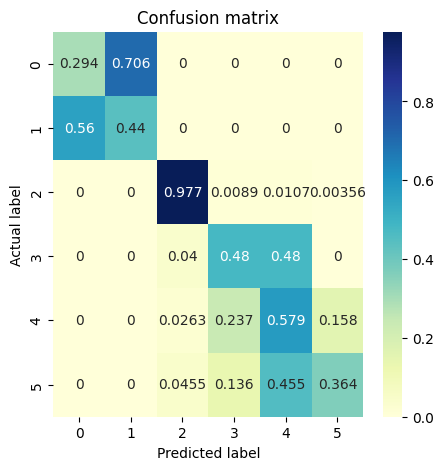

In [78]:

# Model building function
def make_model_ceftriaxone(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_ceftriaxone()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=2000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:2000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**gentamicin**

In [79]:

antibiotic = 'gentamicin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 105.33 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.6003062787136294
Best Validation Loss: 1.09
Best Validation Accuracy: 0.63
Best Train Loss: 0.48
Best Train Accuracy: 0.78


Text(0.5, 25.722222222222214, 'Predicted label')

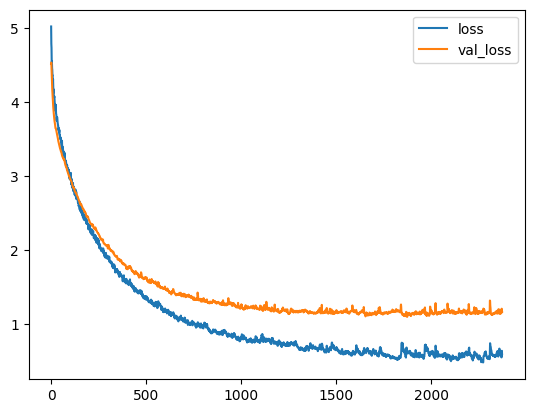

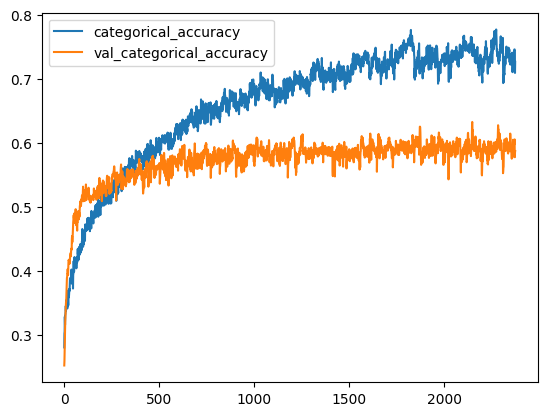

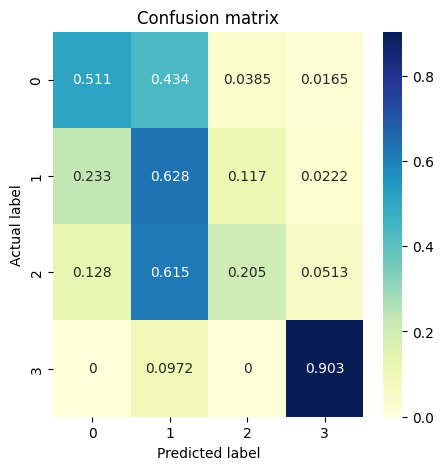

In [80]:

# Model building function
def make_model_gentamicin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=1000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=500,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_gentamicin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=4000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:4000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**ceftiofur**

In [ ]:

antibiotic = 'ceftiofur'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test dataa
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 23.39 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.691358024691358
Best Validation Loss: 1.21
Best Validation Accuracy: 0.74
Best Train Loss: 0.28
Best Train Accuracy: 0.96


Text(0.5, 25.722222222222214, 'Predicted label')

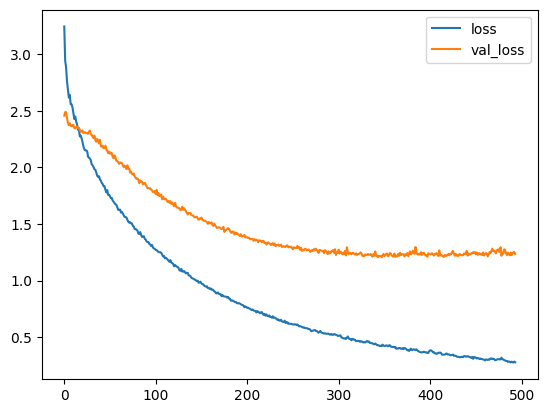

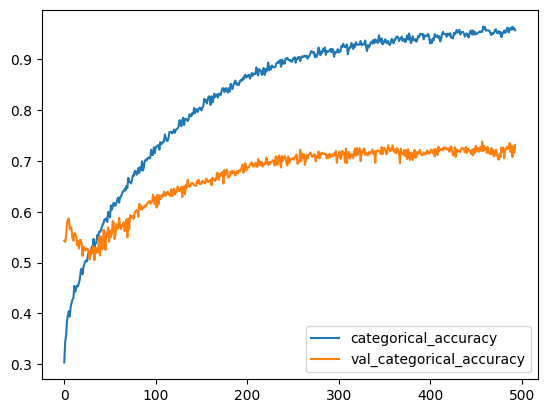

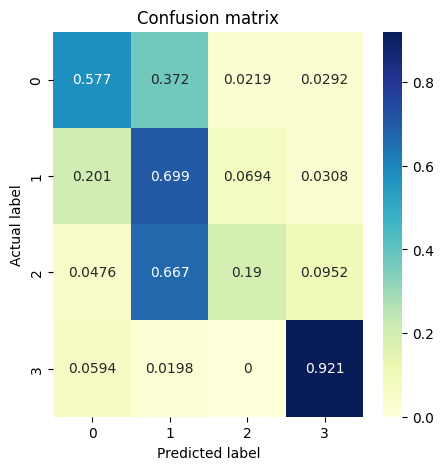

In [82]:

# Model building function
def make_model_ceftiofur(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=150,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_ceftiofur()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:1000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**Ampicillin**


In [83]:

antibiotic = 'ampicillin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 33.58 seconds
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.8308823529411765
Best Validation Loss: 0.89
Best Validation Accuracy: 0.82
Best Train Loss: 0.21
Best Train Accuracy: 0.98


Text(0.5, 25.722222222222214, 'Predicted label')

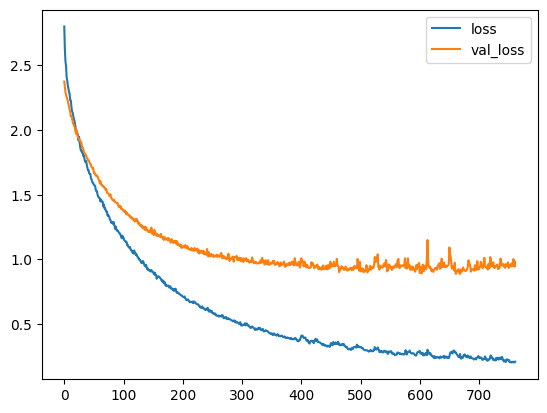

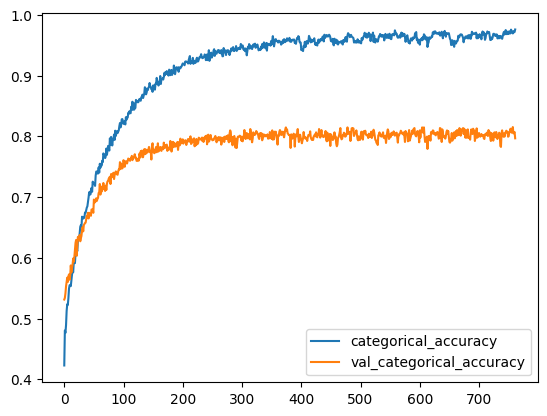

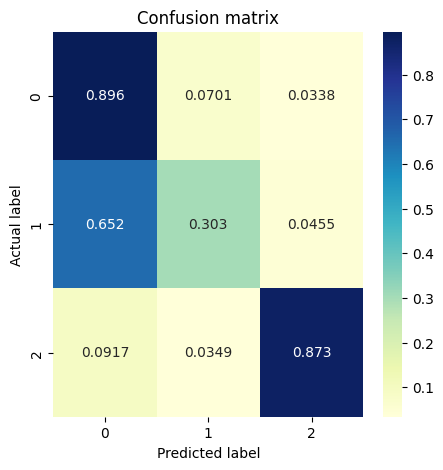

In [84]:

# Model building function
def make_model_ampicillin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_ampicillin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:1000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**amoxicillin/clavulanic acid**

In [85]:
antibiotic = 'amoxicillin/clavulanic acid'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 43.37 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.860248447204969
Best Validation Loss: 0.78
Best Validation Accuracy: 0.84
Best Train Loss: 0.29
Best Train Accuracy: 0.93


Text(0.5, 25.722222222222214, 'Predicted label')

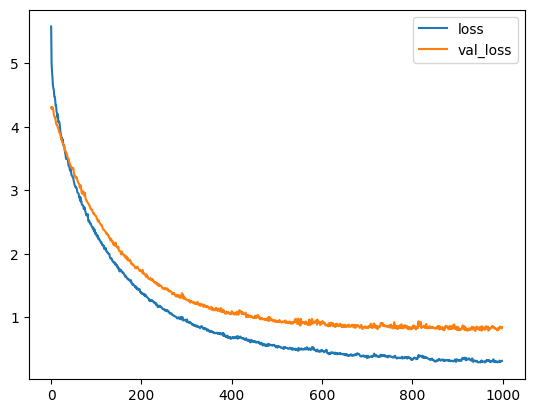

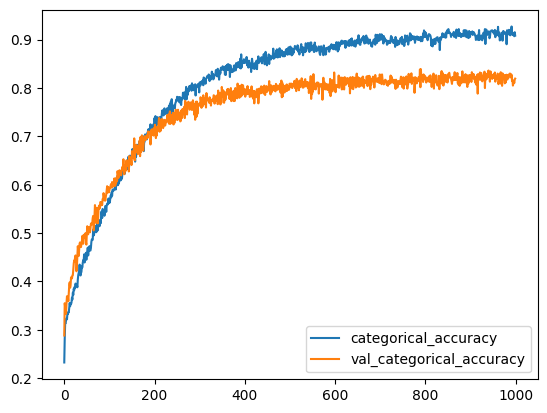

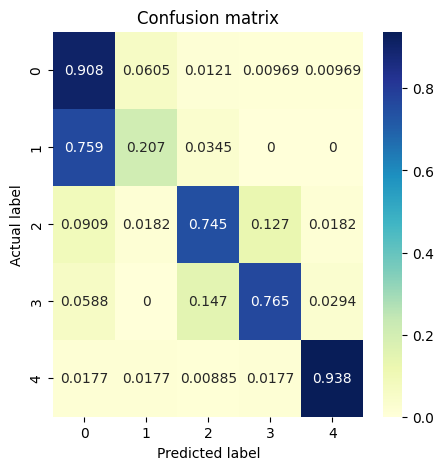

In [86]:
# Model building function
def make_model_amoxicillin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=600,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_amoxicillin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

N_epochs.update({antibiotic:1000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**cefoxitin**

In [87]:
antibiotic = 'cefoxitin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 67.66 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
Test set accuracy: 0.6846153846153846
Best Validation Loss: 1.50
Best Validation Accuracy: 0.69
Best Train Loss: 0.15
Best Train Accuracy: 0.97


Text(0.5, 25.722222222222214, 'Predicted label')

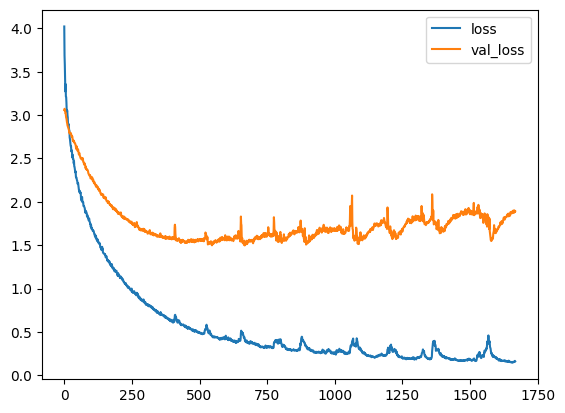

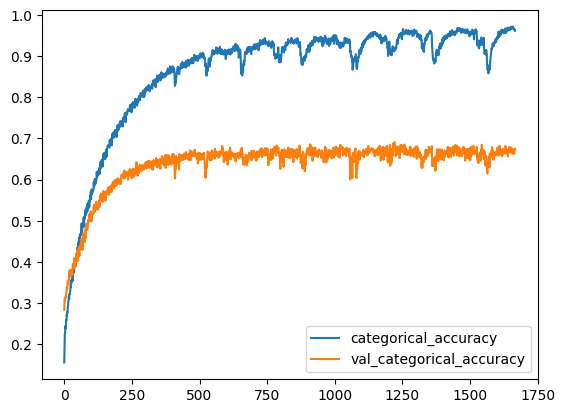

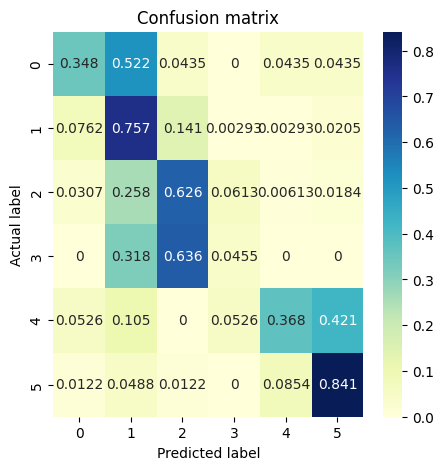

In [88]:
# Model building function
def make_model_cefoxitin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=100000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=1000,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_cefoxitin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=2500,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

N_epochs.update({antibiotic:2500})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**nalidixic acid**

In [89]:
antibiotic = 'nalidixic acid'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 201.72 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Test set accuracy: 0.6831831831831832
Best Validation Loss: 1.33
Best Validation Accuracy: 0.70
Best Train Loss: 0.39
Best Train Accuracy: 0.94


Text(0.5, 25.722222222222214, 'Predicted label')

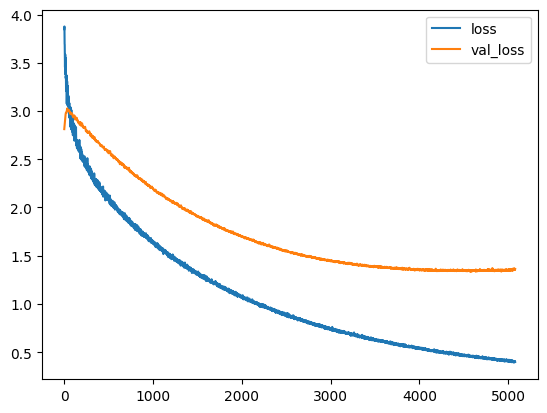

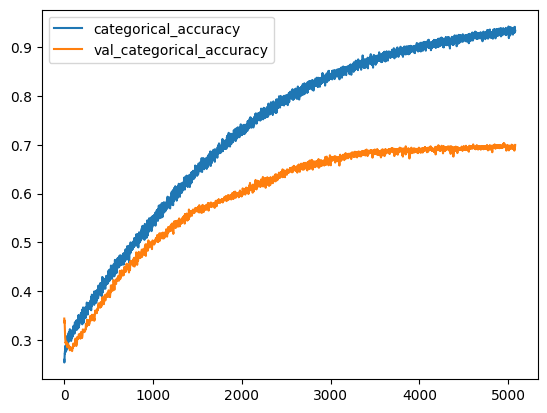

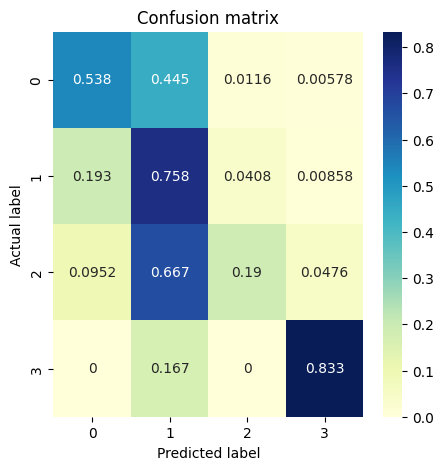

In [90]:
# Model building function
def make_model_nalidixic_acid(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = 0.00001
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=500,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_nalidixic_acid()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=7000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

N_epochs.update({antibiotic:7000})
print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**tetracycline**

In [91]:

antibiotic = 'tetracycline'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 48.33 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.9403669724770642
Best Validation Loss: 0.29
Best Validation Accuracy: 0.94
Best Train Loss: 0.11
Best Train Accuracy: 0.99


Text(0.5, 25.722222222222214, 'Predicted label')

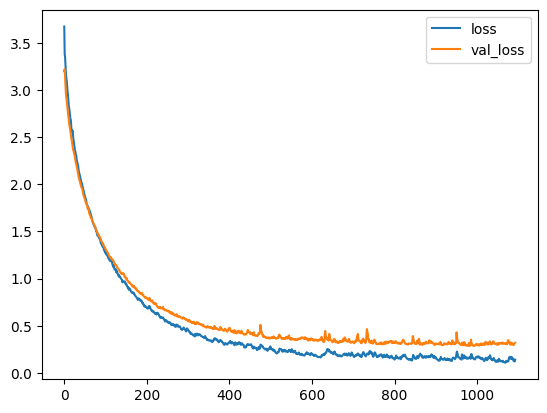

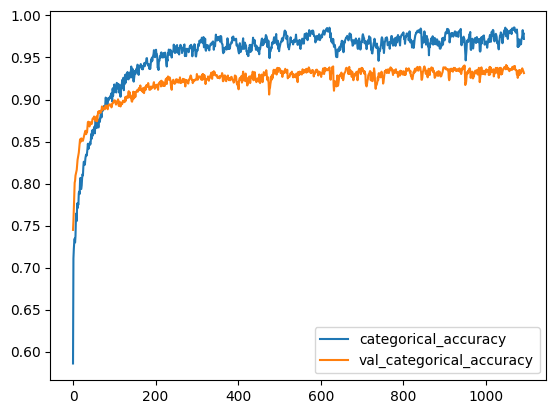

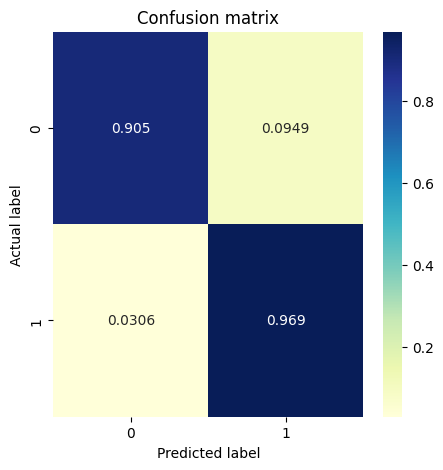

In [92]:

# Model building function
def make_model_tetracycline(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_tetracycline()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1200,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:1200})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**chloramphenicol**

In [93]:
antibiotic = 'chloramphenicol'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 30.98 seconds
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Test set accuracy: 0.7631578947368421
Best Validation Loss: 0.95
Best Validation Accuracy: 0.75
Best Train Loss: 0.31
Best Train Accuracy: 0.91


Text(0.5, 25.722222222222214, 'Predicted label')

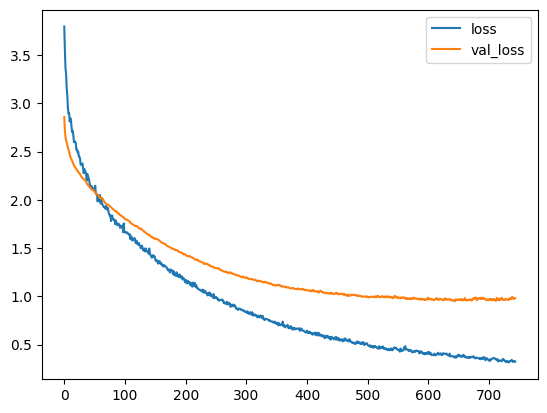

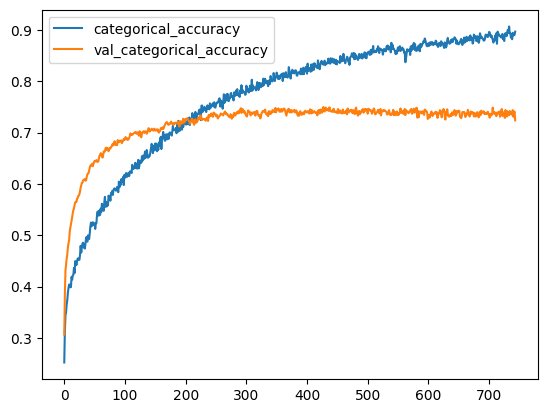

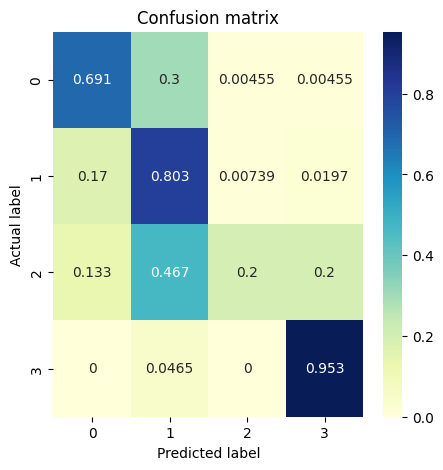

In [94]:

# Model building function
def make_model_chloramphenicol(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_chloramphenicol()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:1000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**sulfisoxazole**

In [95]:
antibiotic = 'sulfisoxazole'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 24.11 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.6035889070146819
Best Validation Loss: 1.34
Best Validation Accuracy: 0.64
Best Train Loss: 0.52
Best Train Accuracy: 0.90


Text(0.5, 25.722222222222214, 'Predicted label')

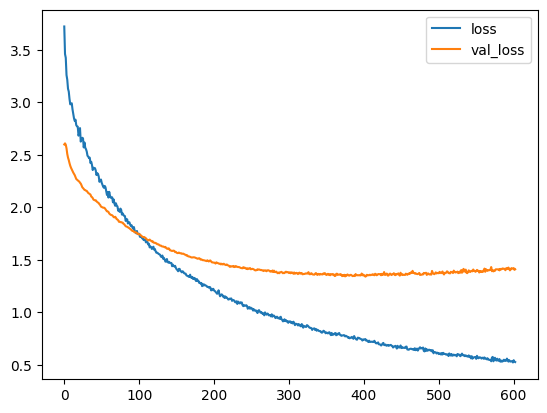

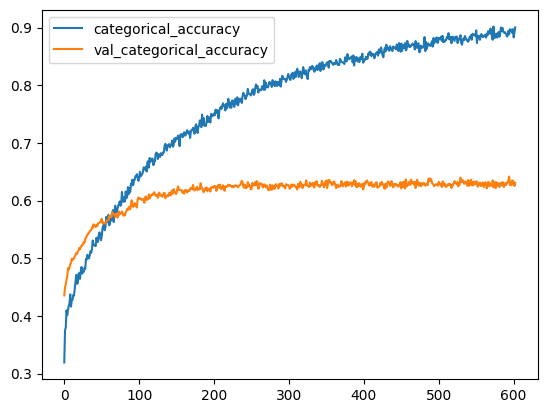

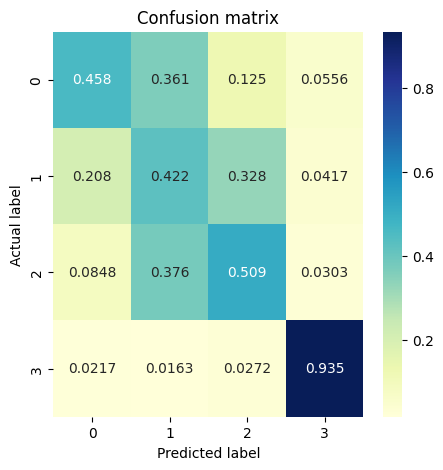

In [96]:

# Model building function
def make_model_sulfisoxazole(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=200,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)
callbacks.update({antibiotic:early_stopping})

starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_sulfisoxazole()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)
N_epochs.update({antibiotic:1000})

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**Resultado Final**

Agora, para testar todos os modelos e comparar com a versão anterior de um modelo para todos.

In [97]:
def kfold_cv_split(X, y, n_splits, kfold):

    total_data = len(X)
    fold_size = total_data // n_splits
    X_folds = []
    y_folds = []
    for i in range(n_splits):
        start  = i * fold_size
        if i < n_splits-1:
            end = start + fold_size
        else:
            end = total_data
        X_folds.append(X[start:end,:])
        y_folds.append(y[start:end])
    
    if kfold == 0:
        train   = kfold + n_splits-2
        val         = kfold + n_splits-2
        test        = kfold + n_splits-1
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 1:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2)
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 2:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
    
    else:
        train   = kfold + (n_splits-2) - n_splits
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate((np.concatenate(X_folds[kfold:]),np.concatenate(X_folds[:train]))), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate((np.concatenate(y_folds[kfold:]),np.concatenate(y_folds[:train]))), y_folds[val], y_folds[test]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def kfold_cross_val(X, y, cv, models, callbacks, N_epochs, antibiotic):
    n_splits=cv
    kfold_accuracy = []
    for kfold in range(n_splits):
        # Split into the training, validation and test data
        X_train, X_val, X_test, y_train, y_val, y_test = kfold_cv_split(X, y, n_splits, kfold)
        # Define the model
        model = models[antibiotic]
        # Training
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=512,
            epochs=N_epochs[antibiotic],
            callbacks=[callbacks[antibiotic]],
            class_weight = class_weights,
            verbose=0,
        )
        # Make predictions, compute the confusion matrix and extract the (per-class) accuracy
        y_pred = model.predict(X_test)
        mic_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
        mic_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
        cm = confusion_matrix(mic_test, mic_pred, normalize='true')
        accuracy = 100*np.diagonal(cm)
        # Save the accuracy per fold
        kfold_accuracy.append(accuracy)
    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy= [a.mean() for a in np.transpose(kfold_accuracy)]
    return average_accuracy

In [98]:
# Initialize a vector to save the average accuracy per antibiotic

#average_accuracies = []
average_accuracies = pd.DataFrame(data={})
for antibiotic in antibiotics:
    
    start_time = time.time()
    
    # Features
    kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)
    X = kmer_dframe.values
    
    # Standardize the training data
    scaler_X = StandardScaler().fit(X)
    X_scaled = scaler_X.transform(X)

    # Target
    y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values
    y_reshape = np.reshape(y,(-1,1))
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_reshape)
    
    # Class weighting
    class_weights = class_weighting(mic_dframe, antibiotic, cv=5)
    
    # Start modeling
    start_modeling_time = time.time()

    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy = kfold_cross_val(X_scaled, y_onehot, cv=5, models=models, callbacks=callbacks, N_epochs=N_epochs, antibiotic=antibiotic)
    
    # Save dataframes with the average accuracy per mic value
    mics = sorted(np.unique(y))
    #average_accuracies.append(pd.DataFrame(average_accuracy, index=mics).T)
    average_accuracies = pd.concat([average_accuracies, pd.DataFrame(average_accuracy, index=mics).T], sort=True, ignore_index=True)
    
    final_modeling_time = time.time()
    
    final_time = time.time()
    
    print('Time: {:0.2f} s, Modeling Time: {:0.2f} s'.format(final_time - start_time, final_modeling_time - start_modeling_time))

# Overall average accuracy
overall_accuracy = average_accuracies

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
Time: 54.21 s, Modeling Time: 42.87 s
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Time: 62.35 s, Modeling Time: 52.25 s
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Time: 39.83 s, Modeling Time: 29.39 s
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
Time: 123.76 s, Modeling Time: 112.97 s
41/41 ━━━━━━━━━━━━━━━━━━━━

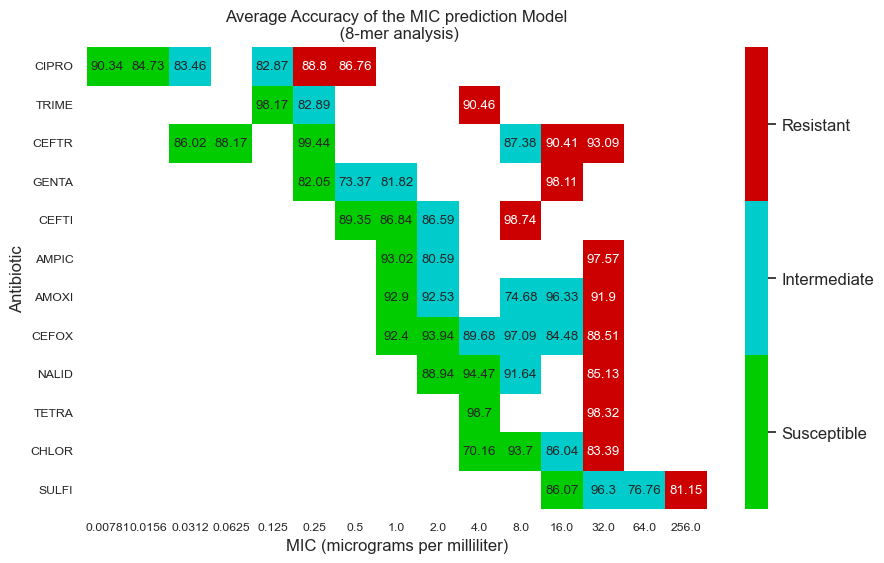

In [99]:
# Plot the overall average accuracy

from matplotlib.colors import LinearSegmentedColormap

def susceptibility_heatmap(data, annot, antibiotics, title):
    sns.set_theme(font_scale=.8, style='white')
    myColors = ((0.0, 0.8, 0.0, 1.0), (0.0, 0.8, 0.8, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    # Abbreviate the antibiotic names to 5 letters
    antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
    # Number of genomes by Antibiotic and MIC.
    data = data.rename(index=antibiotic_abbre)
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))
    # Add title
    plt.title(title, fontsize=12)
    # Heatmap showing the amount of genomes with the same MIC for each MIC, by antibiotic
    hp = sns.heatmap(data=data, annot=annot, cmap=cmap, fmt='.4g')
    # Manually specify colorbar labelling after it's been generated
    colorbar = hp.collections[0].colorbar
    colorbar.set_ticks([0.333, 1, 1.667])
    colorbar.set_ticklabels(['Susceptible', 'Intermediate', 'Resistant'])
    colorbar.ax.tick_params(labelsize=12)
    # Add label for horizontal axes
    plt.xlabel('MIC (micrograms per milliliter)', fontsize=12)
    plt.ylabel('Antibiotic', fontsize=12)

title = 'Average Accuracy of the MIC prediction Model\n (8-mer analysis)'
susceptibility_heatmap(data=suscep_classes, annot=overall_accuracy, antibiotics=antibiotics, title=title)